In [2]:
import os
import hashlib
import numpy as np
import cv2
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from skimage.feature import hog
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. CONFIGURATION ---
DATA_DIR = r'C:/Users/Admin/Downloads/data/dataset'
IMG_SIZE = (128, 128)

In [3]:
def load_unique_features(root_dir):
    features = []
    labels = []
    hashes = set()
    image_extensions = ('.jpg', '.jpeg', '.png')
    
    print("🔍 Cleaning dataset and extracting HOG features...")
    
    for label, folder in enumerate(["Fake", "Real"]):
        folder_path = Path(root_dir) / folder
        if not folder_path.exists(): continue
            
        for img_path in folder_path.glob("*"):
            if img_path.suffix.lower() in image_extensions:
                # A. De-duplication check
                with open(img_path, "rb") as f:
                    img_hash = hashlib.md5(f.read()).hexdigest()
                
                if img_hash in hashes:
                    continue # Skip duplicates
                hashes.add(img_hash)
                
                # B. Load and Preprocess image
                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                if img is None: continue
                img = cv2.resize(img, IMG_SIZE)
                
                # C. HOG Feature Extraction (The "ML" way to see images)
                # This turns pixels into a structural vector
                fd = hog(img, orientations=9, pixels_per_cell=(16, 16),
                        cells_per_block=(2, 2), visualize=False)
                
                features.append(fd)
                labels.append(label)
                
    return np.array(features), np.array(labels)

In [4]:
# Load cleaned data
X, y = load_unique_features(DATA_DIR)
print(f"✅ Dataset Cleaned. Unique images: {len(X)}")

# Split into Train and Test (No leakage possible now!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

🔍 Cleaning dataset and extracting HOG features...
✅ Dataset Cleaned. Unique images: 646


In [5]:
# --- 4. TRAIN THE RANDOM FOREST ---
print("🚀 Training Random Forest (Target: < 1 minute)...")
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

🚀 Training Random Forest (Target: < 1 minute)...


RandomForestClassifier(n_jobs=-1, random_state=42)

In [6]:
# --- 5. TEST THE MODEL ---
print("📊 Testing Model...")
y_pred = model.predict(X_test)


📊 Testing Model...


In [9]:
# Results
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Training Complete!")
print(f"Final Accuracy: {accuracy * 100:.2f}%")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))


✅ Training Complete!
Final Accuracy: 95.38%

Detailed Report:
              precision    recall  f1-score   support

        Fake       0.96      0.93      0.95        58
        Real       0.95      0.97      0.96        72

    accuracy                           0.95       130
   macro avg       0.96      0.95      0.95       130
weighted avg       0.95      0.95      0.95       130



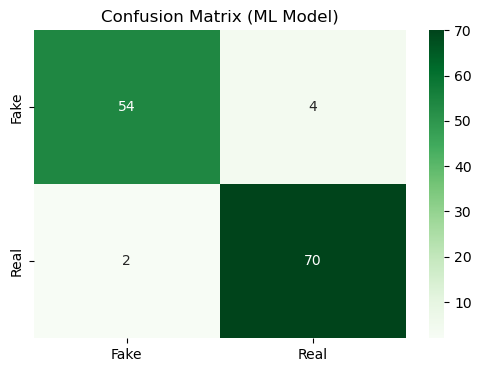

In [8]:
# --- 6. VISUALIZE RESULTS ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix (ML Model)")
plt.show()